In [1]:
import pandas as pd
df = pd.concat(objs=[
    pd.read_csv(filepath_or_buffer='/kaggle/input/gustavosta-nlp-research-prompts/train.csv', ),
    pd.read_csv(filepath_or_buffer='/kaggle/input/gustavosta-nlp-research-prompts/test.csv', )
]).sample(frac=1, random_state=2022).reset_index().drop(columns=['index']).drop_duplicates(ignore_index=True)
df.head()

,Prompt
0,tarot pele hawaiian fire goddess holding molte...
1,Lively sunny landscape of a kerala village rea...
2,portrait of a young spiderman handsome but joy...
3,"Saladin in the style of Berserk, artstation, c..."
4,"donald trump, lord of the undead, portrait pai..."


Let's do a tiny bit of cleanup before we proceed.

In [2]:
def fix(arg: str) -> str:
    for key, value in {'4 k': '4k', '8 k': '8k'}.items():
        arg = arg.replace(key, value)
    return arg

df['Prompt'] = df['Prompt'].apply(fix)

(-0.5, 1199.5, 1199.5, -0.5)

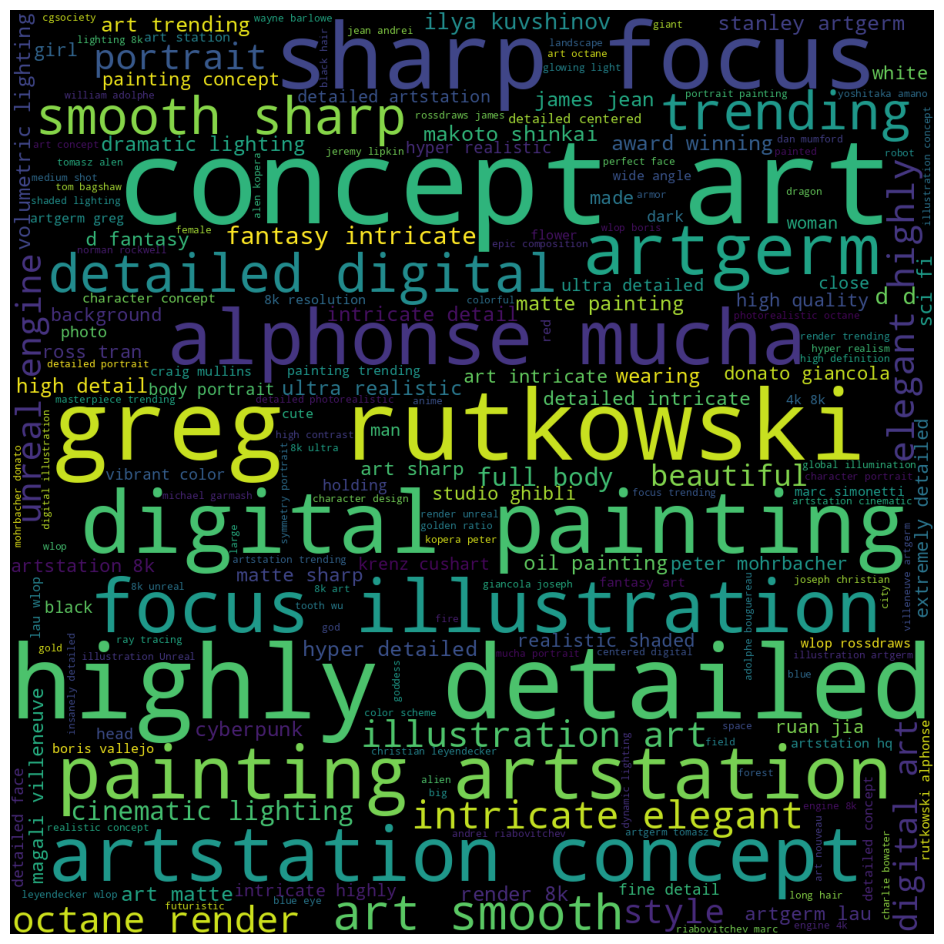

In [3]:
from matplotlib.pyplot import subplots
from matplotlib.pyplot import axis
from matplotlib.pyplot import imshow
from wordcloud import WordCloud
from wordcloud import STOPWORDS

FRACTION = 0.2
subplots(figsize=(12, 12))
text = ' '.join(df.sample(frac=FRACTION, random_state=2023)['Prompt'].values.tolist())
imshow(X=WordCloud(random_state=2023, height=1200, width=1200, stopwords=STOPWORDS,).generate(text=text), )
axis('off')

The terms in the prompts are mostly the names of artists, descriptions of technology, or instrinsic characteristics of the result.

In [4]:
from collections import Counter
from plotly.express import bar
count_df = pd.DataFrame.from_dict(Counter(text.split(',')), orient='index').reset_index().sort_values(ascending=False, by=0)
bar(data_frame=count_df.head(n=50), x='index', y=0)

Our prompts aren't really sentences; if we use a sentence transformer to embed them in a space what should we expect to see in the results? 

In [5]:
%env TOKENIZERS_PARALLELISM=true
! pip install sentence-transformers

env: TOKENIZERS_PARALLELISM=true
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=a8045d070ecb08eb49d4ac293bb59c6fd1c55ca3c731e523134865a5da32d580
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [6]:
# https://www.kaggle.com/code/ianalyticsgeek/keywords-extraction-using-bert
from arrow import now
from sentence_transformers import SentenceTransformer

# we can't use more features than we can visualize
MAX_FEATURES = 300
SAMPLE_SIZE = 10000

model_start = now()
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
# we need to encode the essays to get the words' relationships to each other
embedding = model.encode(df.sample(n=SAMPLE_SIZE, random_state=2023)['Prompt'].values.tolist())
print('{}: got embeddings'.format(now()))
features = count_df.head(n=MAX_FEATURES)['index'].values.tolist()
feature_embeddings = model.encode(features)
print('model time: {}'.format(now() - model_start))

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2023-12-03T17:36:29.237620+00:00: got embeddings


Batches:   0%|          | 0/10 [00:00<?, ?it/s]

model time: 0:07:09.195917


In [7]:
# now we can project the feature vectors into 2-space to visualize 
from pandas import DataFrame
from plotly.express import scatter
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=2023, verbose=1, n_iter=10000)
tsne_df = DataFrame(data=tsne.fit_transform(X=feature_embeddings), columns=['t0', 't1'])
tsne_df['word'] = features
tsne_df['count'] = count_df.head(n=MAX_FEATURES)[0].values.tolist()
scatter(data_frame=tsne_df, x='t0', y='t1', text='word', height=900, hover_data=['count'] ).update_traces(marker={'size': 1})

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.001s...
[t-SNE] Computed neighbors for 300 samples in 0.062s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 4.941994
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.343567
[t-SNE] KL divergence after 10000 iterations: 0.537639


It is probably not surprising that terms get clustered by commmon words; maybe it is a little surprising that the artist names are mostly clustered together. In other words because we don't have much to go on in terms of word order as we would in sentences, the transformer is reduced to doing lexical clustering.